# **Introduction**
In this notebook, we will execute phase3 of the ICS474 project. 


### **Table of Contents**
1. Finding a "Big Dataset" - 1.14GB - ADULTS DATASET.
2. Detailed description of the dataset.
3. Importing libraries and setting up PySpark.
4. Preprocessing the dataset.
5. Sampling the data.
6. Building Kmeans clustering algorithm with different k values and plotting the error rates.
7. Using the model.

<br></br>
Team members (Group3):
 - Amaan Izhar (201781130/Section02)
 - Farhan M. Abdul Qadir (201771950/Section02)
 - AbdulJawad Mohammad (201744310/Section03) 

### **Finding a "Big Dataset" - 1.14GB - ADULTS DATASET.**
We found the dataset on Kaggle. Its size is 1.14GB. 

Link: https://www.kaggle.com/brijeshbmehta/adult-datasets?select=adult10m


### **Detailed description of the dataset.**
   - Dataset Task: Predict whether the income of each adult exceeds $50K per year based on census data.
   - List of Attributes:
       1. Continuous Features:
           - <b>age</b>
           - <b>fnlwgt(Final Weight)</b>
           - <b>education-num</b>
           - <b>capital-gain</b>
           - <b>capital-loss</b>
           - <b>hourse-per-week</b>
       2. Categorical Features:
           - <b>workclass</b>: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous
           - <b>education</b>: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool
           - <b>marital-status</b>: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
           - <b>occupation</b>: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
           - <b>relationship</b>: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
           - <b>race</b>: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black
           - <b>sex</b>: Female, Male
           - <b>native-country</b>: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands
           - <b>SalaryClass</b>: <=50k OR >50k

### **Importing libraries and setting up PySpark.**

In [1]:
import findspark
findspark.init()
print(f'Spark dependency found -> {findspark.find()}')

Spark dependency found -> C:\Spark\spark-3.0.3-bin-hadoop2.7


In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, countDistinct
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

import matplotlib.pyplot as plt 

In [3]:
# Setting up spark.
spark = SparkSession.builder.appName('ICS474Project').getOrCreate()

### **Preprocessing the dataset.**

In [4]:
df = spark.read.csv(path='adult10m', sep=',', inferSchema=False)

In [5]:
columns = ['a', 'wc', 'fw', 'ed', 'edN', 
           'ms', 'oc', 'rel', 'race', 'sex', 
           'cg', 'cl', 'hpw', 'nc', 'salaryClass']

df = df.toDF(*columns)
df.show(5, truncate=False)

+---+----------------+------+---------+---+------------------+-----------------+-------------+-----+------+----+---+---+-------------+-----------+
|a  |wc              |fw    |ed       |edN|ms                |oc               |rel          |race |sex   |cg  |cl |hpw|nc           |salaryClass|
+---+----------------+------+---------+---+------------------+-----------------+-------------+-----+------+----+---+---+-------------+-----------+
|39 |State-gov       |77516 |Bachelors|13 |Never-married     |Adm-clerical     |Not-in-family|White|Male  |2174|0  |40 |United-States|<=50K      |
|50 |Self-emp-not-inc|83311 |Bachelors|13 |Married-civ-spouse|Exec-managerial  |Husband      |White|Male  |0   |0  |13 |United-States|<=50K      |
|38 |Private         |215646|HS-grad  |9  |Divorced          |Handlers-cleaners|Not-in-family|White|Male  |0   |0  |40 |United-States|<=50K      |
|53 |Private         |234721|11th     |7  |Married-civ-spouse|Handlers-cleaners|Husband      |Black|Male  |0   |0  |40

In [6]:
print(f'df shape = {df.count()}, {len(df.columns)}')

df shape = 10000000, 15


In [37]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+---+---+---+---+---+---+----+---+---+---+---+---+-----------+
|  a| wc| fw| ed|edN| ms| oc|rel|race|sex| cg| cl|hpw| nc|salaryClass|
+---+---+---+---+---+---+---+---+----+---+---+---+---+---+-----------+
|  0|  0|  0|  0|  0|  0|  0|  0|   0|  0|  0|  0|  0|  0|          0|
+---+---+---+---+---+---+---+---+----+---+---+---+---+---+-----------+



In [17]:
df.select(countDistinct("a").alias("as"),
          countDistinct("wc").alias("wcs"), 
          countDistinct('edN').alias("edNs"), 
          countDistinct('ms').alias("mss"),
          countDistinct('oc').alias("ocs"),
          countDistinct('rel').alias("rels"), 
          countDistinct('race').alias("races"), 
          countDistinct('sex').alias("sexes"), 
          countDistinct('nc').alias("ncs"), 
          countDistinct('salaryClass').alias("salaryClasses")
          ).show()

+---+---+----+---+---+----+-----+-----+---+-------------+
| as|wcs|edNs|mss|ocs|rels|races|sexes|ncs|salaryClasses|
+---+---+----+---+---+----+-----+-----+---+-------------+
| 73|  9|  16|  7| 15|   6|    5|    2| 42|            2|
+---+---+----+---+---+----+-----+-----+---+-------------+



In [10]:
df.groupBy(df['wc']).count().show()
df.groupBy(df['edN']).count().show()
df.groupBy(df['ms']).count().show()
df.groupBy(df['oc']).count().show()
df.groupBy(df['rel']).count().show()
df.groupBy(df['race']).count().show()
df.groupBy(df['sex']).count().show()
df.groupBy(df['nc']).count().show(30)
df.groupBy(df['salaryClass']).count().show()

+----------------+-------+
|              wc|  count|
+----------------+-------+
|Self-emp-not-inc|1110296|
|       Local-gov|1110045|
|       State-gov|1108295|
|         Private|1129254|
|     Without-pay|1106759|
|     Federal-gov|1108964|
|    Never-worked|1106779|
|               ?|1110548|
|    Self-emp-inc|1109060|
+----------------+-------+

+---+------+
|edN| count|
+---+------+
|  7|623919|
| 15|624516|
| 11|624818|
|  3|621756|
|  8|623454|
| 16|623397|
|  5|623844|
|  6|623061|
|  9|633268|
|  1|622270|
| 10|630730|
|  4|623699|
| 12|623620|
| 13|629065|
| 14|624905|
|  2|623678|
+---+------+

+--------------------+-------+
|                  ms|  count|
+--------------------+-------+
|           Separated|1423556|
|       Never-married|1433420|
|Married-spouse-ab...|1426068|
|            Divorced|1428751|
|             Widowed|1426311|
|   Married-AF-spouse|1423834|
|  Married-civ-spouse|1438060|
+--------------------+-------+

+-----------------+------+
|               oc

In [14]:
df_new = df.select(col('a').cast('double'), col('fw').cast('double'), 
                      col('cg').cast('double'), col('cl').cast('double'),
                      col('hpw').cast('double'), 'wc', 'edN', 'oc', 'salaryClass')
df_new.show(5)

+----+--------+------+---+----+----------------+---+-----------------+-----------+
|   a|      fw|    cg| cl| hpw|              wc|edN|               oc|salaryClass|
+----+--------+------+---+----+----------------+---+-----------------+-----------+
|39.0| 77516.0|2174.0|0.0|40.0|       State-gov| 13|     Adm-clerical|      <=50K|
|50.0| 83311.0|   0.0|0.0|13.0|Self-emp-not-inc| 13|  Exec-managerial|      <=50K|
|38.0|215646.0|   0.0|0.0|40.0|         Private|  9|Handlers-cleaners|      <=50K|
|53.0|234721.0|   0.0|0.0|40.0|         Private|  7|Handlers-cleaners|      <=50K|
|28.0|338409.0|   0.0|0.0|40.0|         Private| 13|   Prof-specialty|      <=50K|
+----+--------+------+---+----+----------------+---+-----------------+-----------+
only showing top 5 rows



In [16]:
# Indexing categorical features.
indexer = StringIndexer(inputCols=['wc', 'edN', 'oc', 'salaryClass'], outputCols=['wc_si', 'edN_si', 'oc_si', 'salaryClass_si']) 
df_indexed = indexer.fit(df_new).transform(df_new) 
df_indexed = df_indexed.drop(*['wc', 'edN', 'oc', 'salaryClass'])
df_indexed.show(5)

# One hot encoding the categorical features.
onehot = OneHotEncoder(inputCols=['wc_si', 'edN_si', 'oc_si'], outputCols=['wc_ohe', 'edN_ohe', 'oc_ohe'])
df_ohe = onehot.fit(df_indexed).transform(df_indexed)
df_ohe.show(5, truncate=False)

for col in ['a', 'fw', 'cg', 'cl', 'hpw']:
    assembler = VectorAssembler(inputCols=[col], outputCol=f'{col}_vec')
    df_ohe = assembler.transform(df_ohe)

    scaler = StandardScaler(inputCol=f'{col}_vec', outputCol=f'{col}_sc')
    df_ohe = scaler.fit(df_ohe).transform(df_ohe)


df_clean = df_ohe.select(['a_sc', 'fw_sc', 'cg_sc', 'cl_sc', 'hpw_sc', 'wc_ohe', 'edN_ohe', 'oc_ohe'])
df_clean.show(5, False)

final_assembler = VectorAssembler(inputCols=['a_sc', 'fw_sc', 'cg_sc', 'cl_sc', 'hpw_sc', 'wc_ohe', 'edN_ohe', 'oc_ohe'], outputCol='features')
final_df = final_assembler.transform(df_clean)
final_df = final_df.select(['features'])
final_df.show(5, False)

+----+--------+------+---+----+-----+------+-----+--------------+
|   a|      fw|    cg| cl| hpw|wc_si|edN_si|oc_si|salaryClass_si|
+----+--------+------+---+----+-----+------+-----+--------------+
|39.0| 77516.0|2174.0|0.0|40.0|  6.0|   2.0|  3.0|           0.0|
|50.0| 83311.0|   0.0|0.0|13.0|  2.0|   2.0|  2.0|           0.0|
|38.0|215646.0|   0.0|0.0|40.0|  0.0|   0.0|  8.0|           0.0|
|53.0|234721.0|   0.0|0.0|40.0|  0.0|   6.0|  8.0|           0.0|
|28.0|338409.0|   0.0|0.0|40.0|  0.0|   2.0|  4.0|           0.0|
+----+--------+------+---+----+-----+------+-----+--------------+
only showing top 5 rows

+----+--------+------+---+----+-----+------+-----+--------------+-------------+--------------+--------------+
|a   |fw      |cg    |cl |hpw |wc_si|edN_si|oc_si|salaryClass_si|wc_ohe       |edN_ohe       |oc_ohe        |
+----+--------+------+---+----+-----+------+-----+--------------+-------------+--------------+--------------+
|39.0|77516.0 |2174.0|0.0|40.0|6.0  |2.0   |3.0  |0

### **Sampling the data.**

As the dataset is huge (10M rows), we will take a sample of it i.e. 40-70% of the data will be sampled first.

In [17]:
final_df = final_df.sample(fraction=0.4, seed=3)
print(f'Size of 40% of sampled data = {final_df.count()}')

Size of 40% of sampled data = 4000664


In [18]:
final_df.show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------+
|features                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------+
|(42,[0,1,2,4,11,15,31],[1.8487061379573442,0.6877735810696858,0.19880196875001743,1.407781753443814,1.0,1.0,1.0])|
|(42,[0,1,4,5,15,32],[1.327276201610401,3.0025900432970136,1.407781753443814,1.0,1.0,1.0])                        |
|(42,[0,1,4,5,16,30],[1.7539006949851728,2.525001048144555,1.407781753443814,1.0,1.0,1.0])                        |
|(42,[0,1,4,5,14,30],[1.7539006949851728,2.4884634093752047,2.815563506887628,1.0,1.0,1.0])                       |
|(42,[0,1,4,5,21,38],[1.6116925305269154,2.178124169152871,1.5837544726242907,1.0,1.0,1.0])                       |
+-----------------------------------------------------------------------

### **Building Kmeans clustering algorithm with different k values and plotting the error rates.**

In [19]:
errors = []
models = {} # dictionary

for k in range(2, 10):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(final_df)
    models[k] = model
    pred = model.transform(final_df)

    # Now, we will compute sum-of-squared-error or squared-eucledian-distance.
    evaluator = ClusteringEvaluator()
    ssed = evaluator.evaluate(pred)
    errors.append(ssed)

    print(f'With K={k}')
    print(f'Silhouette with squared euclidean distance = {ssed:.5f}')
    print('-'*60)

With K=2
Silhouette with squared euclidean distance = 0.67800
------------------------------------------------------------
With K=3
Silhouette with squared euclidean distance = 0.16138
------------------------------------------------------------
With K=4
Silhouette with squared euclidean distance = 0.14453
------------------------------------------------------------
With K=5
Silhouette with squared euclidean distance = 0.15690
------------------------------------------------------------
With K=6
Silhouette with squared euclidean distance = 0.17056
------------------------------------------------------------
With K=7
Silhouette with squared euclidean distance = 0.17451
------------------------------------------------------------
With K=8
Silhouette with squared euclidean distance = 0.17706
------------------------------------------------------------
With K=9
Silhouette with squared euclidean distance = 0.16803
------------------------------------------------------------


Now, we will find the best k by plotting the error rates.

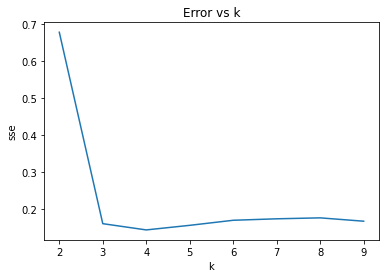

In [20]:
cluster_nums = range(2, 10)
plt.plot(cluster_nums, errors)
plt.xlabel('k')
plt.ylabel('sse')
plt.title('Error vs k')
plt.show()

- As we can see, be elbow method, k=3 produced the least  acceptable error. This signifies that there are 3 clusters where most of the data is distributed. 

### **Using the model.**

In [25]:
# Taking a sample data from the df.
random_samples = final_df.sample(0.1).limit(10)

In [26]:
random_samples.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------+
|features                                                                                                       |
+---------------------------------------------------------------------------------------------------------------+
|(42,[0,1,4,10,20,39],[1.6590952520130013,0.681820022154136,1.407781753443814,1.0,1.0,1.0])                     |
|(42,[0,1,3,4,5,15,30],[2.133122466873859,3.4331893990802445,1.8947438089507587,1.407781753443814,1.0,1.0,1.0]) |
|(42,[0,1,4,5,17,33],[1.6590952520130013,0.49999247691365567,1.407781753443814,1.0,1.0,1.0])                    |
|(42,[0,1,4,5,13,38],[2.2753306313321158,1.3277057468299163,1.407781753443814,1.0,1.0,1.0])                     |
|(42,[0,1,4,5,19,36],[1.4220816445825726,1.7292914846491412,1.407781753443814,1.0,1.0,1.0])                     |
|(42,[0,1,4,5,14,33],[0.9954571512078008,1.7737790321939502,1.407781753443814,1.0,1.0,1.

In [27]:
model_to_use = models[3]
pred_df = model_to_use.transform(random_samples)

In [28]:
pred_df.select(pred_df.features, pred_df.prediction).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------+----------+
|features                                                                                                       |prediction|
+---------------------------------------------------------------------------------------------------------------+----------+
|(42,[0,1,4,10,20,39],[1.6590952520130013,0.681820022154136,1.407781753443814,1.0,1.0,1.0])                     |0         |
|(42,[0,1,3,4,5,15,30],[2.133122466873859,3.4331893990802445,1.8947438089507587,1.407781753443814,1.0,1.0,1.0]) |0         |
|(42,[0,1,4,5,17,33],[1.6590952520130013,0.49999247691365567,1.407781753443814,1.0,1.0,1.0])                    |0         |
|(42,[0,1,4,5,13,38],[2.2753306313321158,1.3277057468299163,1.407781753443814,1.0,1.0,1.0])                     |0         |
|(42,[0,1,4,5,19,36],[1.4220816445825726,1.7292914846491412,1.407781753443814,1.0,1.0,1.0])                     |0         |


As we can see, majority of the random samples selected belong to the cluster#1 indexed as 0. Therefore, it was an exquisite experience using the model.